In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 414 (delta 104), reused 79 (delta 79), pack-reused 250
Receiving objects: 100% (414/414), 70.33 MiB | 23.23 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=fe1faa2ac5aceb81025ce360effa389fa4684d0bb6e9740f54891f2a2018b46a
  Stored in directory: /tmp/pip-ephem-wheel-cache-eolu5gu5/wheels/55/59/29/0fb1c635652157

In [2]:
from dul_2021.utils.hw10_utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [10]:
class Classifier(nn.Module):
    def __init__(self, hd=32):
        super().__init__()

        self.part_1 = nn.Sequential(
                    nn.Conv2d(1, 32, 3, 1, 1), 
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 3, 2, 1),
                    nn.ReLU(), 
                    nn.Conv2d(64, 128, 3, 2, 1), 
                    nn.ReLU(), 
                    nn.Conv2d(128, 128, 3, 2, 1), 
                    nn.ReLU(),
                )

        self.part_2 = nn.Sequential(
                    nn.Linear(4 * 4 * 128, hd), 
                    nn.ReLU(),
                    nn.Linear(hd, hd), 
                    nn.ReLU(),
                    nn.Linear(hd, 1)
                )

    def forward(self, x):
        out = self.part_1(x)
        out = out.view(-1, 4 * 4 * 128)
        out = self.part_2(out)
        return out


class Encoder(nn.Module):
    def __init__(self, ld=128):
        super().__init__()

        self.part_1 = nn.Sequential(
                        nn.Conv2d(1, 32, 3, 1, 1), 
                        nn.ReLU(),
                        nn.Conv2d(32, 64, 3, 2, 1),
                        nn.ReLU(), 
                        nn.Conv2d(64, 128, 3, 2, 1), 
                        nn.ReLU(), 
                        nn.Conv2d(128, 128, 3, 2, 1), 
                        nn.ReLU(), 
                )

        self.part_2 = nn.Linear(4 * 4 * 128, ld)

    def forward(self, x):
        bs = x.shape[0]
        out = self.part_1(x)
        out = out.view(-1, 4 * 4 * 128)
        out = self.part_2(out)
        return out


class Decoder(nn.Module):
    def __init__(self, ld=128):
        super().__init__()

        self.part_1 = nn.Sequential(
                        nn.Linear(ld, 4 * 4 * 128), 
                        nn.ReLU()
                )
        
        self.part_2 = nn.Sequential(
                            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
                            nn.ReLU(), 
                            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
                            nn.ReLU(), 
                            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
                            nn.ReLU(), 
                            nn.Conv2d(32, 1, 3, 1, 1)
                            )

    def forward(self, x):
        out = self.part_1(x)
        out = out.view(-1, 128, 4, 4)
        out = self.part_2(out)
        return out


def get_center_crop_mask(image_size=28, crop_size=14):
    M = torch.zeros(image_size, image_size, dtype=int)
    indent = (image_size - crop_size) // 2
    M[indent: -indent, indent: -indent] = 1
    return M.bool().to(device)


class ContextEncoder(nn.Module):
    def __init__(self, nd=32, ld=32, hd=32):
        super().__init__()

        self.D = Classifier(hd=hd)
        self.enc = Encoder(ld=ld)
        self.dec = Decoder(ld=ld)
        self.mask = get_center_crop_mask()


    def dis_loss(self, x):
        # for D updating
        # log(D(x)) + log(1 - D(x_rec)) --> max

        bs = x.shape[0]
        rec_x = self.dec(self.enc(x * ~self.mask))
        t1 = self.D(x).sigmoid().log()
        t2 = (1 - self.D(rec_x).sigmoid()).log()
        loss = -(t1 + t2)
        return loss.mean()


    def rec_loss(self, x):
        # for AE updating
        # MSE + log(1 - D(x_rec)) --> min
        # MSE + log(D(x_rec)) --> min

        bs = x.shape[0]
        rec_x = self.dec(self.enc(x * ~self.mask))
        L_rec = self.mask * (x - rec_x)
        L_rec = (L_rec.reshape(bs, -1) ** 2).sum(1) #.mean() # MSE

        # дополнительно
        disc_out = self.D(rec_x).sigmoid()
        # f_loss = disc_out.sigmoid().log()
        labels = torch.ones_like(disc_out).to(device)
        f_loss = F.binary_cross_entropy(disc_out, labels)

        return L_rec.mean(), (L_rec + f_loss).mean()


    def fit(self, train_data, n_critic=10, lr=1e-3, num_epochs=20, 
            bs=128, betas=(0.9, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)

        ae_opt = opt.Adam(list(self.enc.parameters()) + list(self.dec.parameters()), lr=lr, betas=betas)
        dis_opt = opt.Adam(self.D.parameters(), lr=lr, betas=betas)

        
        train_loss_AE = []
        train_loss_D = []
        
        for epoch in tqdm(range(num_epochs)):
            t_losses_AE = []
            t_losses_D = []

            for i, r_batch in enumerate(tqdm(trainloader)):
                r_batch = r_batch.float().to(device)

                # обновляем модель
                rec_loss, ae_loss = self.rec_loss(r_batch)
                ae_opt.zero_grad()
                ae_loss.backward()
                ae_opt.step()
                    
                cur_loss = rec_loss.item()
                train_loss_AE.append(cur_loss)
                t_losses_AE.append(cur_loss)


                loss = self.dis_loss(r_batch)
                cur_loss = loss.item()
                train_loss_D.append(cur_loss)
                t_losses_D.append(cur_loss)
                if (i + 1) % n_critic == 0:
                    # обновляем clf на каждом n_critic-м шаге
                    dis_opt.zero_grad()
                    loss.backward()
                    dis_opt.step()

            print(f'Epoch {epoch + 1}: ae_loss= {np.mean(t_losses_AE):.5f}, clf_loss= {np.mean(t_losses_D):.5f}')

        return np.array(train_loss_AE), np.array(train_loss_D)

In [11]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """

    train_data, train_labels = zip(*train_data)
    train_data = torch.stack(train_data, dim=0)

    # test_data, test_labels = zip(*test_data)
    # test_data = torch.stack(test_data, dim=0)

    model = ContextEncoder()
    model.to(device)
    ae_losses, clf_losses = model.fit(train_data)

    # examples
    ids = torch.randint(0, len(train_data), (10,))
    x = train_data[ids].to(device)
    x_masked = x * ~model.mask
    x_rec_ = model.dec(model.enc(x_masked))
    x_rec = x_masked * ~model.mask + x_rec_ * model.mask
    examples = torch.cat([x, x_masked, x_rec], dim=0).detach().cpu().numpy()

    return ae_losses, clf_losses, examples


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: ae_loss= 92.55721, clf_loss= 1.17221


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: ae_loss= 57.24554, clf_loss= 0.77216


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: ae_loss= 53.03522, clf_loss= 0.41382


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: ae_loss= 51.05917, clf_loss= 0.33833


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: ae_loss= 49.47894, clf_loss= 0.32950


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: ae_loss= 48.90983, clf_loss= 0.35572


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: ae_loss= 48.19492, clf_loss= 0.37319


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: ae_loss= 47.84671, clf_loss= 0.42153


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: ae_loss= 47.54214, clf_loss= 0.42848


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: ae_loss= 47.57211, clf_loss= 0.48996


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11: ae_loss= 47.83101, clf_loss= 0.56212


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12: ae_loss= 46.99761, clf_loss= 0.58738


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13: ae_loss= 46.27716, clf_loss= 0.57578


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14: ae_loss= 46.42201, clf_loss= 0.59661


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15: ae_loss= 46.94585, clf_loss= 0.75458


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16: ae_loss= 46.90779, clf_loss= 0.78390


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17: ae_loss= 45.66780, clf_loss= 0.77833


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18: ae_loss= 44.99289, clf_loss= 0.75328


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19: ae_loss= 44.36338, clf_loss= 0.78712


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20: ae_loss= 43.85107, clf_loss= 0.80549


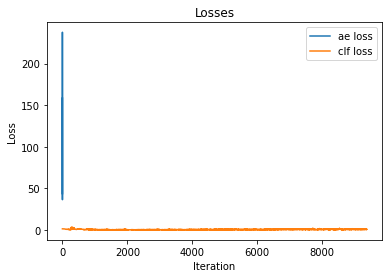

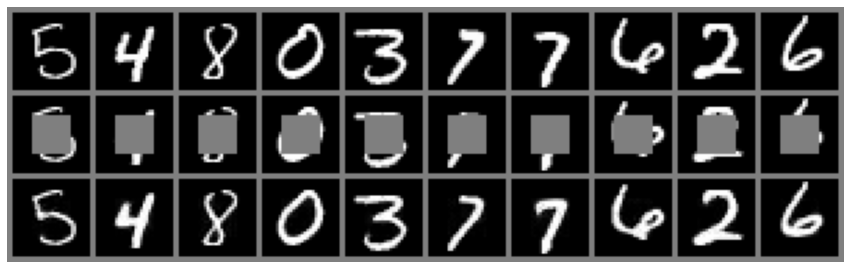

In [12]:
q1_results(q1)

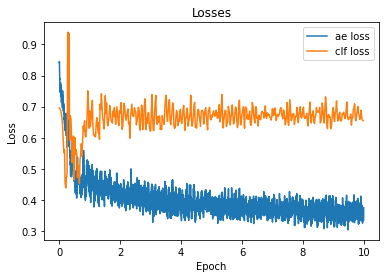

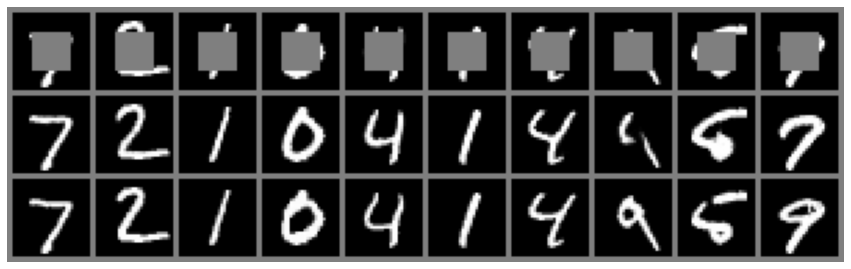

In [ ]:
q1_results(q1) # ref

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [ ]:
from torchvision.transforms.functional import rotate

class Classifier(nn.Module):
    def __init__(self, ld=128, hd=256, out_dim=4):
        super().__init__()

        self.clf = nn.Sequential(
                    nn.Linear(ld, hd), 
                    nn.ReLU(),
                    nn.Linear(hd, out_dim))

    def forward(self, x):
        out = self.clf(x)
        return out


class Encoder(nn.Module):
    def __init__(self, ld=128):
        super().__init__()

        self.part_1 = nn.Sequential(
                        nn.Conv2d(1, 32, 3, 1, 1), 
                        nn.ReLU(),
                        nn.Conv2d(32, 64, 3, 2, 1),
                        nn.ReLU(), 
                        nn.Conv2d(64, 128, 3, 2, 1), 
                        nn.ReLU(), 
                        nn.Conv2d(128, 128, 3, 2, 1), 
                        nn.ReLU(), 
                )

        self.part_2 = nn.Linear(4 * 4 * 128, ld)

    def forward(self, x):
        bs = x.shape[0]
        out = self.part_1(x)
        out = out.view(-1, 4 * 4 * 128)
        out = self.part_2(out)
        return out


class RotNet(nn.Module):
    def __init__(self, ld=128, hd=256):
        super().__init__()

        self.D = Classifier(ld=ld, hd=hd)
        self.F = Encoder(ld=ld)


    def loss(self, x):
        bs = x.shape[0]
        labels = torch.cat([torch.ones(bs) * 0,
                            torch.ones(bs) * 1,
                            torch.ones(bs) * 2,
                            torch.ones(bs) * 3]).long().to(device)
        
        xs = torch.cat([x, rotate(x, 90),
                           rotate(x, 180),
                           rotate(x, 270)])

        embeddings = self.F(xs)
        logits = self.D(embeddings)

        with torch.no_grad():
            pred_labels = torch.argmax(logits.detach(), dim=1).reshape(-1)
            acc = torch.mean((labels == pred_labels).float())

        loss = F.cross_entropy(logits, labels)
        return loss, acc.item()


    def fit(self, train_data, lr=1e-3, num_epochs=10, 
            bs=128, betas=(0.9, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)

        optim = opt.Adam(list(self.F.parameters()) + list(self.D.parameters()), lr=lr, betas=betas)
        
        train_loss = []
        train_accuracy = []
        for epoch in tqdm(range(num_epochs)):
            t_losses = []
            t_acc = []
            for i, r_batch in enumerate(tqdm(trainloader)):
                r_batch = r_batch.float().to(device)

                # обновляем модель
                loss, acc = self.loss(r_batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                    
                cur_loss = loss.item()
                train_loss.append(cur_loss)
                

                t_losses.append(cur_loss)
                t_acc.append(acc)

            print(f'Epoch {epoch + 1}: loss= {np.mean(t_losses):.5f}, accuracy= {np.mean(t_acc):.5f}')
            train_accuracy.append(np.mean(t_acc))
        return np.array(train_loss), np.array(train_accuracy)

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """

    train_data, train_labels = zip(*train_data)
    train_data = torch.stack(train_data, dim=0)

    model = RotNet()
    model.to(device)
    losses, accuracies = model.fit(train_data)
    return losses, accuracies

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: loss= 0.08863, accuracy= 0.96829


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: loss= 0.02280, accuracy= 0.99215


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: loss= 0.02016, accuracy= 0.99298


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: loss= 0.01912, accuracy= 0.99324


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: loss= 0.01401, accuracy= 0.99520


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: loss= 0.01558, accuracy= 0.99456


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: loss= 0.01447, accuracy= 0.99498


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: loss= 0.01147, accuracy= 0.99582


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: loss= 0.01279, accuracy= 0.99556


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: loss= 0.01186, accuracy= 0.99593


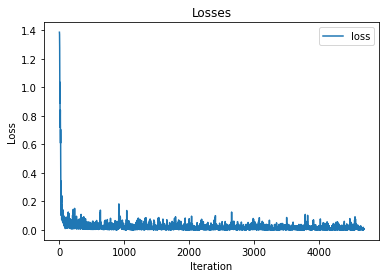

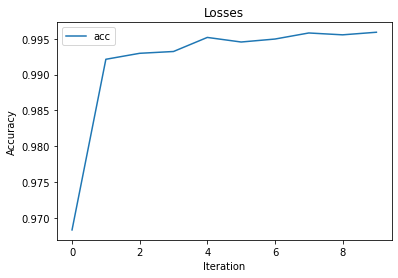

In [ ]:
q2_results(q2)

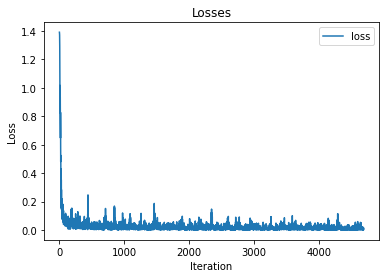

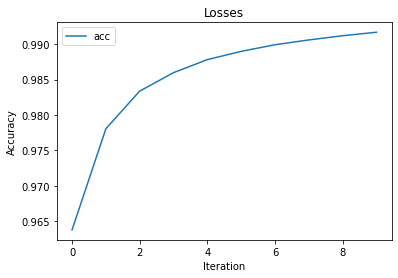

In [ ]:
q2_results(q2) # ref